In [299]:
from __future__ import absolute_import, division, print_function

import pathlib
from copy import deepcopy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.12.0


In [300]:
dataset_path = '/Users/froggityfrog/Documents/UNI/vkr/cian_db.csv'

In [301]:
column_names = ["Id", "Метро", "Расстояние до метро", "Время до метро", "Улица", "Дом", "Стены", 
                "Комнат", "Общая площадь", "Жилая площадь", "Кухня", "Этаж", "Этажность", 
                "Лифт (пасс.)", "Лифт (груз.)", "Балкон", "Лоджия", "С/у (разд.)", "С/у (совм.)", 
                "lng", "lat", "Цена (руб.)", "валюта цены", "Новостройка"]

In [177]:
sample_path = '/Users/froggityfrog/Documents/UNI/vkr/cian_db_sample.csv'

In [305]:
data = pd.read_csv(dataset_path, na_values = "?", delimiter=";", names=column_names, skiprows=1)
dataset = data.copy()
dataset.head()

,Id,Метро,Расстояние до метро,Время до метро,Улица,Дом,Стены,Комнат,Общая площадь,Жилая площадь,...,Лифт (груз.),Балкон,Лоджия,С/у (разд.),С/у (совм.),lng,lat,Цена (руб.),валюта цены,Новостройка
0,228082,Цветной бульвар,671,10,переулок Пушкарев,19,кирпич,3,67.0,58.0,...,0,0,0,0,1,55.769043,37.630122,"38,601,840",1,0
1,234279,Маяковская,274,4,1-я Тверская-Ямская улица,11,нет данных,3,120.0,72.0,...,0,1,0,1,1,55.772578,37.591027,"62,000,000",2,0
2,243558,Водный стадион,1779,27,Береговая улица,4К1,не заполнено,3,120.0,90.0,...,1,0,0,1,1,55.827737,37.467284,"77,203,680",1,0
3,262790,Кропоткинская,736,11,Молочный переулок,7,монолит-кирпич,7,517.0,517.0,...,0,0,0,0,0,55.738992,37.600666,"1,125,887,000",1,0
4,262796,Кропоткинская,736,11,Молочный переулок,7,монолит-кирпич,5,260.0,260.0,...,0,0,0,0,0,55.738992,37.600666,"585,461,240",1,0


In [306]:
df1 = dataset[['Комнат', 'Общая площадь', 'Жилая площадь', 'Цена (руб.)']]

In [307]:
for row in df1.iterrows():
    df1.at[row[0], 'Цена (руб.)'] = int(row[1][-1].replace(',', ''))

In [308]:
train_dataset = df1.sample(frac=0.8,random_state=0)
test_dataset = df1.drop(train_dataset.index)

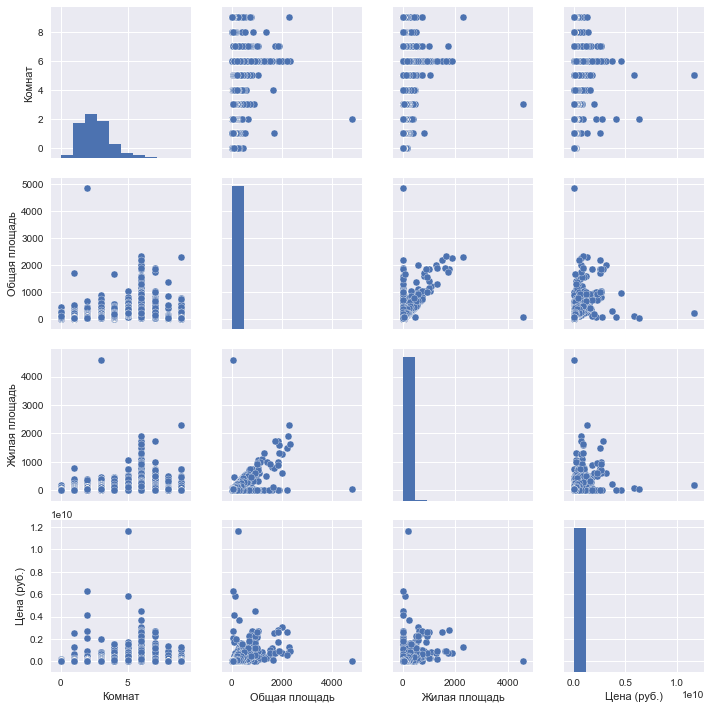

In [309]:
sns.pairplot(train_dataset[['Комнат', 'Общая площадь', 'Жилая площадь', 'Цена (руб.)']])

In [310]:
train_stats = train_dataset.describe()
#train_stats.pop('Цена (руб.)')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Комнат,93876.0,2.451287,1.408289,0.0,1.0,2.0,3.0,9.0
Общая площадь,93876.0,88.456249,78.046268,0.0,45.0,65.0,103.0,4830.0
Жилая площадь,93876.0,46.331611,54.280009,0.0,19.3,32.9,55.0,4600.0


In [311]:
train_labels = train_dataset.pop('Цена (руб.)')
test_labels = test_dataset.pop('Цена (руб.)')

In [312]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
#train_dataset['Цена (руб.)'] = pd.to_numeric(train_dataset['Цена (руб.)'])

In [314]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse', 'acc'])
    return model

In [315]:
model = build_model()

In [316]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  normed_train_data, train_labels,
  epochs=1000, validation_split = 0.2, verbose=1,
  callbacks=[early_stop])

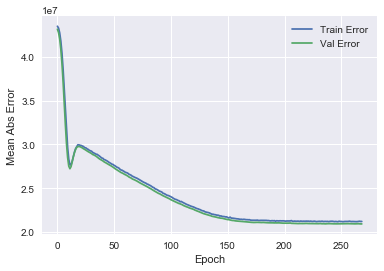

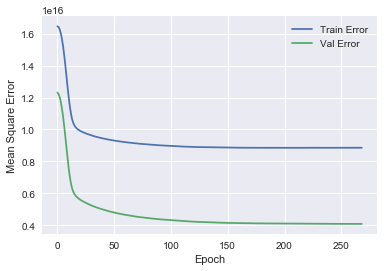

In [319]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    
plot_history(history)

In [320]:
loss, mae, mse, acc = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 21296016.04


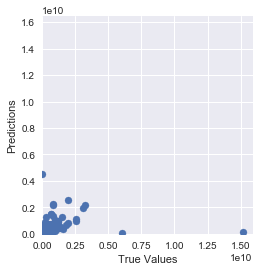

In [321]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])